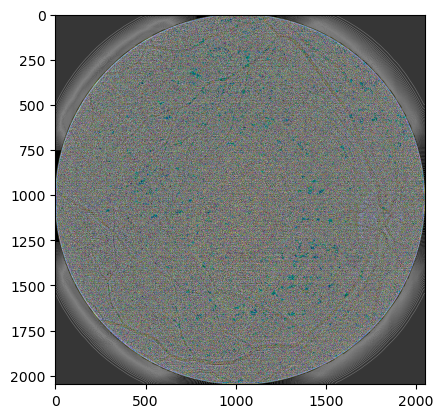

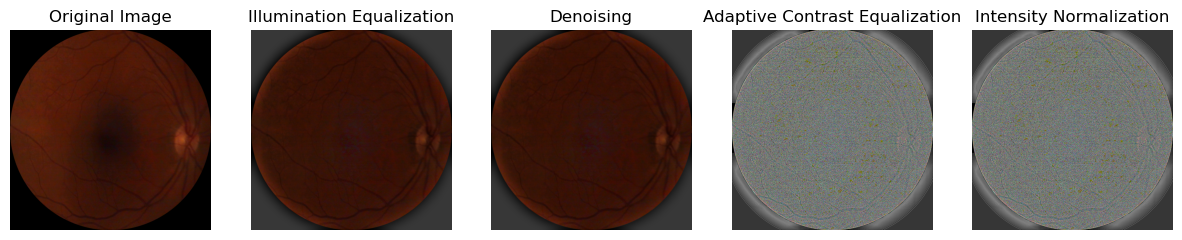

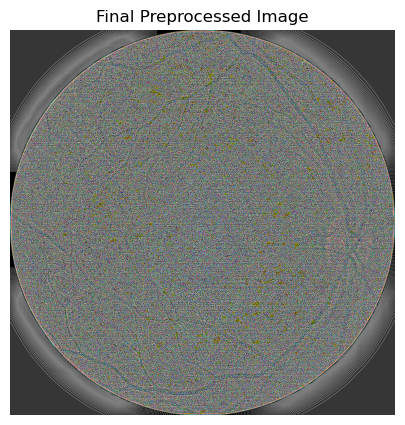

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images(images, titles):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    if n == 1:
        axs = [axs]
    for i in range(n):
        axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) if images[i].ndim == 3 and images[i].shape[2] == 3 else images[i], cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

def fundus_roi(image, mask=None):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    threshold = 15
    _, roi = cv2.threshold(v, threshold, 1, cv2.THRESH_BINARY)
    roi = roi.astype(np.uint8)
    white_pixels = np.argwhere(roi == 1)
    if white_pixels.size == 0:
        print("Aucun pixel blanc trouvé dans le masque.")
        return {"roi": roi, "diameter": 0, "image": image}
    x_min, y_min = np.min(white_pixels, axis=0)
    x_max, y_max = np.max(white_pixels, axis=0)
    diameter_x = x_max - x_min
    diameter_y = y_max - y_min
    diameter = int(np.maximum(diameter_x, diameter_y))
    return {"roi": roi, "diameter": diameter, "image": image}

def mean_filter(channel, kernel_size):
    kernel_size = int(kernel_size)
    if kernel_size % 2 == 0:
        kernel_size += 1
    filtered_channel = cv2.blur(channel, (kernel_size, kernel_size))
    return filtered_channel.astype(np.uint8)

def illumination_equalization(image, diameter=None, roi=None):
    if diameter is None:
        print('Erreur: Le diamètre est None. Impossible de continuer.')
        return None
    kernel_size = int(diameter / 10)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_filtered = mean_filter(v, kernel_size)
    mean_v = np.mean(v)
    v_final = cv2.addWeighted(v, 1, v_filtered, -1, mean_v)
    hsv_final = cv2.merge([h, s, v_final])
    image_final = cv2.cvtColor(hsv_final, cv2.COLOR_HSV2BGR)
    return {"image": image_final, "diameter": diameter}

def denoising(image, diameter=None, roi=None):
    if diameter is None:
        print('Erreur: Le diamètre est None dans denoising. Impossible de continuer.')
        return None
    kernel_size = int(diameter / 360)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_filtered = mean_filter(v, kernel_size)
    hsv_denoised = cv2.merge([h, s, v_filtered])
    denoising_image = cv2.cvtColor(hsv_denoised, cv2.COLOR_HSV2BGR)
    return {"image": denoising_image, "diameter": diameter}

def adaptive_contrast_equalization(image, diameter=None, roi=None):
    if diameter is None:
        print('Erreur: Le diamètre est None dans adaptive_contrast_equalization. Impossible de continuer.')
        return None
    image = image.astype(np.float32) / 255.0
    kernel_size = int(diameter / 10)
    E_x = mean_filter(image, kernel_size)
    E_x2 = mean_filter(image ** 2, kernel_size)
    var = E_x2 - E_x ** 2
    std = np.sqrt(np.maximum(var, 1e-7)) 
    high_pass_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) / 9.0
    convolution = cv2.filter2D(image, -1, high_pass_filter)
    epsilon = 1e-7
    image_final = image + (1 / (std + epsilon)) * convolution
    image_final = np.nan_to_num(image_final, nan=0.5, posinf=1.0, neginf=0.0)
    image_final = np.clip(image_final, 0, 1)
    return {"image": (image_final * 255).astype(np.uint8)}

def apply_intensity_normalization(image, diameter=None, roi=None):
    if not isinstance(image, np.ndarray):
        print('Erreur: L\'image n\'est pas une numpy array valide.')
        return None
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_normalized = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    hsv_normalized = cv2.merge([h, s, v_normalized])
    image_final = cv2.cvtColor(hsv_normalized, cv2.COLOR_HSV2BGR)

    plt.imshow(image_final)
    plt.show()

    return {"image": image_final}

def apply_seoud(image):
    images = []
    titles = []

    data = fundus_roi(image)
    images.append(image)
    titles.append("Original Image")
    
    illumination = illumination_equalization(**data)
    if illumination is None:
        print('Erreur lors de l\'égalisation de l\'illumination.')
        return None
    images.append(illumination["image"])
    titles.append("Illumination Equalization")

    denoise = denoising(**illumination)
    if denoise is None:
        print('Erreur lors de la réduction de bruit.')
        return None
    images.append(denoise["image"])
    titles.append("Denoising")

    contrast = adaptive_contrast_equalization(**denoise)
    images.append(contrast["image"])  
    titles.append("Adaptive Contrast Equalization")

    normalized_image = apply_intensity_normalization(**contrast)  
    images.append(normalized_image["image"])  
    titles.append("Intensity Normalization")

    plot_images(images, titles)
    return normalized_image["image"]

# Chargement de l'image
image = cv2.imread('../data/image_1.png')
if image is None:
    print("Erreur: Impossible de charger l'image.")
else:
    image = image.astype(np.uint8)
    seoud_image = apply_seoud(image)
    if seoud_image is not None:
        plot_images([seoud_image], ['Final Preprocessed Image'])
